In [3]:
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb

# load data
df = pd.read_csv('ratings_Electronics.csv') 
df=pd.DataFrame(df)
df.columns = ["userID","itemID","rating","timestamp"] #adding column head, convert rating into purchase

In [4]:
df.head()

,userID,itemID,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [5]:
#split the dataset for training
from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.datasets.download_utils import maybe_download
from recommenders.datasets.python_splitters import python_random_split,python_chrono_split,python_stratified_split

from recommenders.datasets.spark_splitters import spark_random_split

In [6]:
df_train, df_test = python_random_split(df, ratio=0.7)
df_train.shape[0], df_test.shape[0]

(5477136, 2347345)

In [7]:
x_train = df_train[['userID', 'itemID']]
y_train = df_train[['rating']]
x_test = df_test[['userID', 'itemID']]
y_test = df_test['rating']

In [9]:
# load data
data_path = 'ml-100k/'
train_path = data_path + 'u1.base'
test_path = data_path + 'u1.test'

# load train and test data
df = pd.read_csv(train_path, delimiter = '\t', names = ['userid', 'itemid', 'rating', 'timestamp'])
test = pd.read_csv(test_path, delimiter = '\t', names = ['userid', 'itemid', 'rating', 'timestamp'])

x_train = df[['userid', 'itemid']]
y_train = df[['rating']]
x_test = test[['userid', 'itemid']]
y_test = test['rating']

In [21]:
user.head()

,id,age,gender,administrator,artist,doctor,educator,engineer,entertainment,executive,...,marketing,none,other,programmer,retired,salesman,scientist,student,technician,writer
0,1,24,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,53,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,23,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,24,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,33,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
item.head()

,movie id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [10]:
# load data
user = pd.read_csv(data_path+'u.user', delimiter = '|', names = ['id', 'age', 'gender', 'occupation', 'zip'])[['id', 'age', 'gender', 'occupation']]
genre = pd.read_csv(data_path+'u.genre', delimiter = '|', names = ['genre', 'id']).genre.to_list()
occupation_col_names =  pd.read_csv(data_path+'u.occupation', delimiter = '|', names = ['occupation'])['occupation'].to_list()

# perform one-hot encoding on the user's occupation column, and label encoding on the gender column
user[occupation_col_names] = preprocessing.OneHotEncoder(sparse = False).fit_transform(user.occupation.to_numpy().reshape(-1,1))
user['gender'] = preprocessing.LabelEncoder().fit_transform(user.gender)
user = user.drop(['occupation'], axis = 1)

# notice that the genre is already in the one-hot encoding format in the movie dataset, 
# so we can simply load the movie data
item_col_names = ['movie id','movie title','release date','video release date','IMDb URL'] + genre
item = pd.read_csv(data_path+'u.item', delimiter = '|', names = item_col_names, encoding = 'latin1')[['movie id'] + genre]

# Next we merge the movie and user data with our train and test dataset
x_train = x_train.join(user.set_index('id'), on = 'userid').join(item.set_index('movie id'), on = 'itemid')
x_test = x_test.join(user.set_index('id'), on = 'userid').join(item.set_index('movie id'), on = 'itemid')

x_train.head()

,userid,itemid,age,gender,administrator,artist,doctor,educator,engineer,entertainment,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,24,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,24,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,1,3,24,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,1,4,24,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,5,24,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
model1 = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000, max_depth=20, verbosity=2)
model1.fit(x_train, y_train)

pred1 = model1.predict(x_test)
rmse = np.sqrt(np.mean((pred1 - y_test.to_numpy())**2))
print(f'content-based rmse = {rmse}')

In [13]:
test.head()

,userid,itemid,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [23]:
#item-item collaborative filtering model
def compute_single_prediction(userid, itemid, similarity_mtx, utility):
    user_rating = utility.iloc[:,userid-1]
    item_similarity = similarity_mtx[itemid-1]
    numerate = np.dot(user_rating, item_similarity)
    denom = item_similarity[user_rating > 0].sum()
            
    if denom == 0 or numerate == 0:
        return user_rating[user_rating>0].mean()
    
    return numerate / denom

def compute_all_prediction(test_set, pred_func, similarity_mtx, utility, **kwargs):
    pred = []
    for data in test_set:
        res = pred_func(userid = data[0], 
                        itemid = data[1], 
                        similarity_mtx = similarity_mtx, 
                        utility = utility, 
                        **kwargs)
        pred.append(res)
    return pred
  
  

In [24]:
# model 2
# construct the utility matrix
utility = df.pivot(index = 'itemid', columns = 'userid', values = 'rating')
utility = utility.fillna(0)

# calculate the similarity
similarity_mtx = 1 - squareform(pdist(utility, 'cosine'))

pred2 = compute_all_prediction(test[['userid', 'itemid']].to_numpy(),
                      compute_single_prediction,
                      similarity_mtx,
                      utility)
pred2 = np.array(pred2)

rmse = np.sqrt(np.mean((pred2 - y_test.to_numpy())**2))
print(f'rmse of item-item collaborative filtering = {rmse}')

rmse of item-item collaborative filtering = 1.0452369678411928


In [40]:
pred_rating

array([[1.        , 0.35764638, 0.30938972, ..., 0.        , 0.05103519,
        0.05103519],
       [0.35764638, 1.        , 0.22160009, ..., 0.        , 0.08778086,
        0.08778086],
       [0.30938972, 0.22160009, 1.        , ..., 0.        , 0.        ,
        0.10666772],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.05103519, 0.08778086, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.05103519, 0.08778086, 0.10666772, ..., 0.        , 0.        ,
        1.        ]])

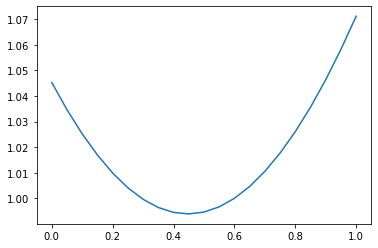

In [25]:
# build the weighted hybrid by combinig the 2 models in linear manner
chart_val = []

w = np.linspace(0,1,21)

for i in w:
    pred4 = pred1*i + pred2*(1-i)
    rmse = np.sqrt(np.mean((pred4 - y_test.to_numpy())**2))
    chart_val.append([i, rmse])

chart_val_np = np.array(chart_val)
plt.plot(chart_val_np[:, 0], chart_val_np[:,1])

In [54]:
def calculate_user_rating(userid, similarity_mtx, utility):
    user_rating = utility.iloc[:,userid-1]
    pred_rating = deepcopy(user_rating)
    
    default_rating = user_rating[user_rating>0].mean()
    numerate = np.dot(similarity_mtx, user_rating)
    corr_sim = similarity_mtx[:, user_rating >0]
    for i,ix in enumerate(pred_rating):
        temp = 0
        if ix < 1:
            w_r = numerate[i]
            sum_w = corr_sim[i,:].sum()
            if w_r == 0 or sum_w == 0:
                temp = default_rating
            else:
                temp = w_r / sum_w
            pred_rating.iloc[i] = temp
    return pred_rating
def recommendation_to_user(userid, top_n, similarity_mtx, utility):
    user_rating = utility.iloc[:,userid-1]
    pred_rating = calculate_user_rating(userid, similarity_mtx, utility)

    top_item = sorted(range(1,len(pred_rating)), key = lambda i: -1*pred_rating.iloc[i])
    top_item = list(filter(lambda x: user_rating.iloc[x]==0, top_item))[:top_n]
    res = []
    for i in top_item:
        res.append(tuple([i, pred_rating.iloc[i]]))
    
    return res

In [56]:
recommendation_to_user(5,10,similarity_mtx, utility)

[(1340, 5.0),
 (1621, 4.370313666390961),
 (1226, 4.288788333174737),
 (1479, 4.28726274600945),
 (1334, 4.116365004548509),
 (1358, 4.0403178364489705),
 (1330, 4.0),
 (1183, 3.9890196548790526),
 (1374, 3.9822387113270508),
 (1401, 3.9822387113270508)]